<a href="https://colab.research.google.com/github/tayfunai/CNN-IMAGE-CLASSIFICATION-MODELS/blob/main/VGG_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. VGG-19 Image Classification on CIFAR-10

### 1. Imports

In [ ]:
import os
import time

import pandas as pd
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

### 2. Model Settings

In [ ]:
### SETTINGS ####

# hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 256
NUM_EPOCHS = 20

# Architecture
NUM_FEATURES = 32*32*3
NUM_CLASSES = 10
IN_CHANNELS = 3

#Other
DEVICE = "cuda" if torch.cuda.is_available else 'cpu'

### 3.CIFAR-10 Dataset


In [ ]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.ToTensor()
])

In [ ]:
train_dataset = datasets.CIFAR10(
    root='data',
    train=True,
    transform=train_transform,
    download=True)

test_dataset = datasets.CIFAR10(
    root='data',
    train=False,
    transform=transform_test,
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=2,
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=2,
    shuffle=False
)

# Checking the dataset

for images, labels in train_loader:
  print(f'Images batch demension: {images.shape}')
  print(f'Labels batch demension: {labels.shape}')
  break

for images, labels in test_loader:
  print(f'Images batch demension: {images.shape}')
  print(f'Labels batch demension: {labels.shape}')
  break

Images batch demension: torch.Size([256, 3, 32, 32])
Labels batch demension: torch.Size([256])
Images batch demension: torch.Size([256, 3, 32, 32])
Labels batch demension: torch.Size([256])


In [ ]:
device = torch.device(DEVICE)

torch.manual_seed(0)

for epoch in range(2):
  for batch_idx, (x, y) in enumerate(train_loader):
    print('Epoch:', epoch+1, end='')
    print(' | Batch index:', batch_idx, end='')
    print(' | Batch size:', y.size()[0])
    try:
      x = x.to(device)
      y = y.to(device)
    except:
      pass

    break

Epoch: 1 | Batch index: 0 | Batch size: 256
Epoch: 2 | Batch index: 0 | Batch size: 256


### 4. MODEL ARCHITECTURE

In [ ]:
## MODEL ##

class VGG19(nn.Module):
  def __init__(self, in_channels, num_classes):
    super(VGG19, self).__init__()

    self.in_channels = in_channels
    self.num_classes = num_classes

    self.features = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),

        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),

        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),

        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),

        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),


        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),

        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),

        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),

        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),

        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )

    self.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(512*1*1, 4096),
        nn.ReLU(),

        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(),
        nn.Linear(4096, num_classes)
    )

  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    logits = self.fc(x)
    # probas = F.softmax(logits, dim=1)

    return logits


### 4. Model Training and Evaluation

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary

#### 4.1 Create train and test loop functions

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

  #Put model in train mode
  model.train()
  model = model.to(DEVICE)
  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(DEVICE), y.to(DEVICE)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumulate accuracy metrics accross all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc  += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [ ]:
def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,):
  # Put model in eval mode
  model.eval()
  model = model.to(DEVICE)
  # Set up test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on infernece context manager
  with torch.inference_mode():
    # Loop through DataLoder batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(DEVICE), y.to(DEVICE)


      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate and accumulate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate and accumulate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += (test_pred_labels == y).sum().item()/len(test_pred_labels)

    # Adjust metrics to get avarage loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc



In [ ]:
# we use tqdm to add progress bar while training
!pip install tqdm
from tqdm.auto import tqdm

In [ ]:
# Create a train() by combining train_step() and test_step()
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int):
  # 1. Create empty results dictionary
  results = {
      "train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # 2. Loop through training and teting steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    # 4. Print out what's happenin
    print(
        f"Epoch: {epoch+1} | "
        f"train_loss: {train_loss:.4f} | "
        f"train_acc: {train_acc:.4f} | "
        f"test_loss: {test_loss:.4f} | "
        f"test_acc: {test_acc:.4f}"
    )

    # 5. Update results dictionary
    # I have to make sure all data is moved to CPU and converted to float for storage
    results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
    results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
    results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

  # 6. return filled results at the end of the epoch
  return results


#### 4.2 training and evaluating model

In [ ]:
# Set random seeds
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

# Recreate an instance of VGG19
model = VGG19(IN_CHANNELS, NUM_CLASSES)

# Move our model to target device
model = model.to(DEVICE)

# Set up loss function and optimizer

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
loss_fn = torch.nn.CrossEntropyLoss()

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model
model_results = train(model,
                      train_dataloader=train_loader,
                      test_dataloader=test_loader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

In [ ]:
model

VGG19(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(

### 5. Plot the loss curves of Model

In [ ]:
model_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [ ]:
from typing import Tuple, Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):

  # Get the loss values of reults dictionary (training and test)
  loss = results['train_loss']
  test_loss = results['test_loss']

  # Get the accuracy values of the results dictionary (training and test)
  accuracy = results['train_acc']
  test_accuracy = results['test_acc']

  # Figure out how many epochs there were
  epochs = range(len(results['train_loss']))

  # Setup a plot
  plt.figure(figsize=(15,7))

  # Plot loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label='train_loss')
  plt.plot(epochs, test_loss, label='test_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot Accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label='train_accuracy')
  plt.plot(epochs, test_accuracy, label='train_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

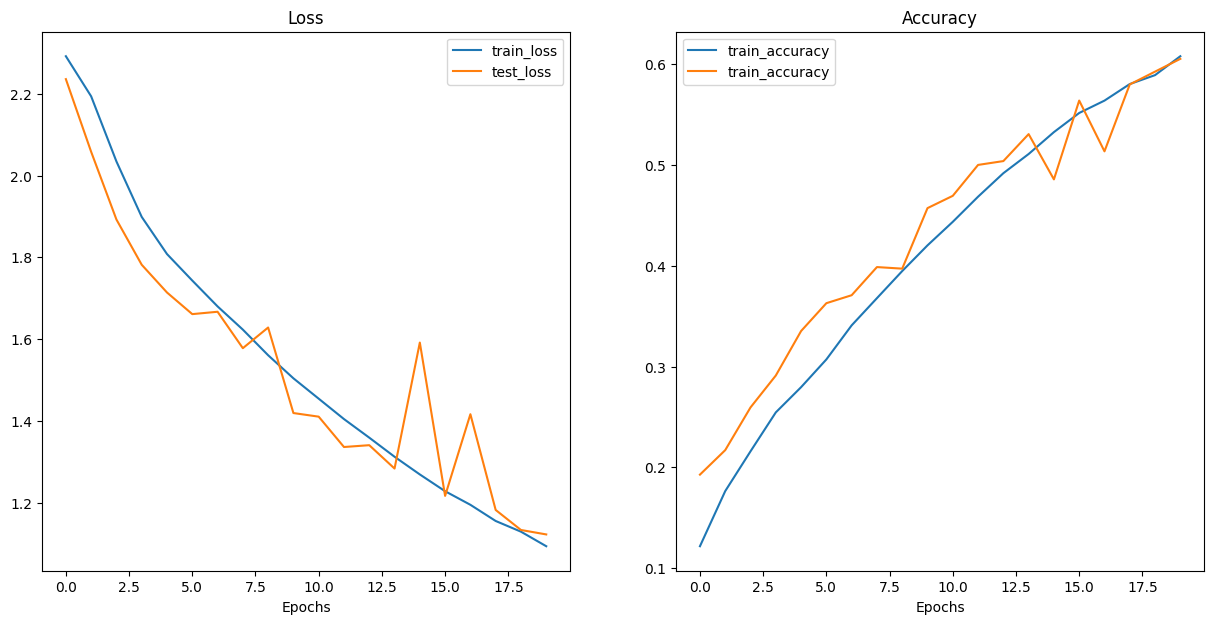

In [ ]:
plot_loss_curves(model_results)

In [ ]:
import os

# Define your path
save_path = '/content/models_chest_xray/VGG19_tuned_state_dict.pth'

# Create directory if it doesn't exist
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save the model
torch.save(model.state_dict(), save_path)


In [ ]:
save_path_model = '/content/models_chest_xray/VGG19_tuned.pth'
# Create directory if it doesn't exist
os.makedirs(os.path.dirname(save_path_model), exist_ok=True)
torch.save(model, save_path_model)


In [ ]:
!zip -r my_models.zip /content/models_chest_xray


  adding: content/models_chest_xray/ (stored 0%)
  adding: content/models_chest_xray/VGG19_tuned.pth (deflated 6%)
  adding: content/models_chest_xray/VGG19_tuned_state_dict.pth (deflated 6%)


In [ ]:
from google.colab import files
files.download("my_models.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
torch.save(model, save_path_model)


## 2. Image Classification with VGG19 onChest X-Ray Images (Pneumonia) dataset

### 0. MODEL SETTINGS

In [ ]:
### SETTINGS ###
#Hyperparameter
import torch
LEARNING_RATE = 0.001
NUM_EPOCHS = 20
BATCH_SIZE = 64

# Architecture
NUM_CLASSES = 2
IN_CHANNELS = 3

# Other
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
RANDOM_SEED = 42

### 1 Downloading dataset into chest_xray folder

You can find dataset from following link
https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?resource=download

In [ ]:
from google.colab import files
files.upload()  # Upload the kaggle.json file here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tayfun777","key":"c2fde40ae8ecc583a03e4f993ccbc716"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!pip install -q kaggle


In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content --force

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.28G/2.29G [00:31<00:00, 102MB/s] 
100% 2.29G/2.29G [00:32<00:00, 76.9MB/s]


In [ ]:
!unzip -q /content/chest-xray-pneumonia.zip -d /content/chest_xray_data

In [ ]:
%cd /content/chest_xray_data/chest_xray

/content/chest_xray_data/chest_xray


In [ ]:
%cd /content/chest_xray_data/chest_xray

/content/chest_xray_data/chest_xray


In [ ]:
%ls

chest_xray/  __MACOSX/  test/  train/  val/


In [ ]:
!rm -rf /content/chest_xray_data/chest_xray/__MACOSX

In [ ]:
!rm -rf /content/chest_xray_data/chest_xray/chest_xray

In [ ]:
!mv /content/chest_xray_data/chest_xray /content/

### 2 Exploring dataset folders all images

In [ ]:
import os
def walk_through_dir(dir_path):
  print(dir_path)
  for dirpath, dirnames, filnames in os.walk(dir_path):
      print(dirpath)
      print(f"There are {len(dirnames)} directories and {len(filnames)} images in '{dirpath}'.")


In [ ]:
walk_through_dir('/content/chest_xray')

/content/chest_xray
/content/chest_xray
There are 3 directories and 0 images in '/content/chest_xray'.
/content/chest_xray/train
There are 2 directories and 0 images in '/content/chest_xray/train'.
/content/chest_xray/train/NORMAL
There are 0 directories and 1341 images in '/content/chest_xray/train/NORMAL'.
/content/chest_xray/train/PNEUMONIA
There are 0 directories and 3875 images in '/content/chest_xray/train/PNEUMONIA'.
/content/chest_xray/val
There are 2 directories and 0 images in '/content/chest_xray/val'.
/content/chest_xray/val/NORMAL
There are 0 directories and 8 images in '/content/chest_xray/val/NORMAL'.
/content/chest_xray/val/PNEUMONIA
There are 0 directories and 8 images in '/content/chest_xray/val/PNEUMONIA'.
/content/chest_xray/test
There are 2 directories and 0 images in '/content/chest_xray/test'.
/content/chest_xray/test/NORMAL
There are 0 directories and 234 images in '/content/chest_xray/test/NORMAL'.
/content/chest_xray/test/PNEUMONIA
There are 0 directories and 

In [ ]:
dir_path = '/content/chest_xray'
train_dir =  os.path.join(dir_path, 'train')
test_dir =  os.path.join(dir_path, 'test')
val_dir =  os.path.join(dir_path, 'val')

In [ ]:
train_dir
import pathlib as pathlib

### 3. Create a custom Dataset to replicate ImageFolder

In [ ]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """ finds the class folder names in a target directory
      by scanning target directory
  """
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
  class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
  return classes, class_to_idx


In [ ]:
# Write a custom dataset
from torch.utils.data import Dataset

# 1. Subclass a torch.utils.data.Dataset
class ImageFolderCustom(Dataset):

  # 2. Initialize our custom dataset
  def __init__(self,
               targ_dir: str,
               transform=None):
    # 3. Create class attributes
    # Get all of the image path
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpeg"))

    # Setup transform
    self.transform = transform

    # Create classes and class_to_index attributes
    self.classeses, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images
  def load_image(self, index: int) -> Image.Image:
    "Opens and transforms an image into a PyTorch image"
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len__()
  def __len__(self) -> int:
    return len(self.paths)

  # 6. Overwrite __get_item() method to return a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx

In [ ]:
find_classes(train_dir)

(['NORMAL', 'PNEUMONIA'], {'NORMAL': 0, 'PNEUMONIA': 1})

In [ ]:
# Create a transform

"""
  For data aguemntation I used the types of image transformation given
  following research paper
  https://pmc.ncbi.nlm.nih.gov/articles/PMC10252226/
"""

train_transforms = transforms.Compose([
    transforms.Lambda(lambda image: image.convert("RGB")),
    transforms.Resize(size=(32,32)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Lambda(lambda image: image.convert("RGB")),
    transforms.Resize(size=(32,32)),
    transforms.ToTensor()
])
val_transform = transforms.Compose([
    transforms.Lambda(lambda image: image.convert("RGB")),
    transforms.Resize(size=(32,32)),
    transforms.ToTensor()
])


In [ ]:
# Test out ImageFolderCustom
train_data = ImageFolderCustom(train_dir, transform=train_transforms)
test_data = ImageFolderCustom(test_dir, transform=test_transforms)
val_data = ImageFolderCustom(val_dir, transform=val_transform)

In [ ]:
len(train_data), len(test_data), len(val_data)

(5216, 624, 16)

In [ ]:
BATCH_SIZE=64
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True)
test_loader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False)
val_loader = DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    shuffle=False)

In [ ]:
for batch_idx, (images, labels) in enumerate(train_loader):
  print(images.shape, labels.shape)
  break

for batch_idx, (images, labels) in enumerate(test_loader):
  print(images.shape, labels.shape)
  break

for batch_idx, (images, labels) in enumerate(val_loader):
  print(images.shape, labels.shape)
  break

torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([16, 3, 32, 32]) torch.Size([16])


### 4. Model training i use pretrained VGG19 model and transfer learning

In [ ]:
## SETTING UP ##
## IMPORTS ##

import os, time
from tempfile import TemporaryDirectory

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split



In [ ]:
model = models.vgg19(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
NUM_CLASSES = 2
# Modify the model head for fine-tuning
model.classifier = nn.Sequential(
  nn.Dropout(p=0.5, inplace=False),
  nn.Linear(in_features=512*1*1, out_features=4096, bias=True),
  nn.ReLU(),
  nn.Dropout(p=0.5, inplace=False),
  nn.Linear(in_features=4096, out_features=4096, bias=True),
  nn.ReLU(),
  nn.Linear(in_features=4096, out_features=2, bias=True)
)
model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

In [ ]:
# Define your optimizer with weight decay
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
# Define the loss function - For classification problem
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# Freeze only the convolutional layers of the pre-trained model
for param in model.parameters():
    if isinstance(param, nn.Conv2d):
        param.requires_grad = False

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(DEVICE)
LEARNING_RATE = 0.001
NUM_EPOCHS=30
RANDOM_SEED = 42
# Set random seeds
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)



# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model
model_results = train(model,
                      train_dataloader=train_loader,
                      test_dataloader=test_loader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2354 | train_acc: 0.9005 | test_loss: 0.4535 | test_acc: 0.8318
Epoch: 2 | train_loss: 0.1429 | train_acc: 0.9503 | test_loss: 0.5102 | test_acc: 0.8234
Epoch: 3 | train_loss: 0.0965 | train_acc: 0.9627 | test_loss: 1.1414 | test_acc: 0.7297
Epoch: 4 | train_loss: 0.0963 | train_acc: 0.9647 | test_loss: 1.0749 | test_acc: 0.8422
Epoch: 5 | train_loss: 0.0965 | train_acc: 0.9661 | test_loss: 0.5771 | test_acc: 0.8297
Epoch: 6 | train_loss: 0.0878 | train_acc: 0.9680 | test_loss: 0.6024 | test_acc: 0.8557
Epoch: 7 | train_loss: 0.0860 | train_acc: 0.9729 | test_loss: 0.6991 | test_acc: 0.8297
Epoch: 8 | train_loss: 0.0755 | train_acc: 0.9728 | test_loss: 1.3900 | test_acc: 0.7453
Epoch: 9 | train_loss: 0.0664 | train_acc: 0.9745 | test_loss: 1.0556 | test_acc: 0.8000
Epoch: 10 | train_loss: 0.0772 | train_acc: 0.9693 | test_loss: 0.8651 | test_acc: 0.8094
Epoch: 11 | train_loss: 0.0643 | train_acc: 0.9769 | test_loss: 0.9140 | test_acc: 0.7891
Epoch: 12 | train_l

In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
%reset -f


In [ ]:
import torch
torch.cuda.empty_cache()
torch.cuda.ipc_collect()




> **Note:** Training VGG19 from scratch on cifar10 dataset which results ***60% ***accuracy on training and ***58%*** on testing. After that Fine tuning VGG19 pre-trained model for detecting pneumonia on Chest X-Ray Images (Pneumonia) dataset, achieving accuracy of ***98%*** and ***82%***, on training and testing, respectively.


